In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import pickle
from time import time

In [2]:
import cifar_pre_process
dt = cifar_pre_process.CifarPreProcess()
dt.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


# Import network, layers and functions

In [3]:
from network import Sequential,layers
from layers import conv2d,max_pool,flatten,dense,dropout
import functions
import numpy as np

# Make Sequential Model

In [7]:
model=Sequential()

In [8]:
model.add(conv2d(num_kernels=32,kernel_size=3,activation=functions.relu,input_shape=(32,32,3)))
model.add(conv2d(num_kernels=32,kernel_size=3,activation=functions.relu))
model.add(max_pool())              #TODO- ADD ACTIVATION LAYER LATER, conv2d can echo
model.add(dropout(0.2))
model.add(conv2d(num_kernels=64,kernel_size=3,activation=functions.relu))
model.add(conv2d(num_kernels=64,kernel_size=3,activation=functions.relu))
model.add(max_pool())
model.add(dropout(0.3))
model.add(conv2d(num_kernels=128,kernel_size=3,activation=functions.relu))
model.add(conv2d(num_kernels=128,kernel_size=3,activation=functions.relu))
model.add(max_pool())
model.add(dropout(0.4))
model.add(flatten())
model.add(dense(1024,activation=functions.relu))
model.add(dropout(0.5))
model.add(dense(512,activation=functions.relu))
model.add(dropout(0.4))
model.add(dense(10,activation=functions.softmax))

# View Model Summary

In [9]:
model.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Name (type)                     Output Shape             Activation        Param #
input_layer (InputLayer)       (None, 32, 32, 3)          echo             0
__________________________________________________________________________________________
conv2d (conv2d)                (None, 32, 32, 32)         relu             896
__________________________________________________________________________________________
conv2d (conv2d)                (None, 32, 32, 32)         relu             9248
__________________________________________________________________________________________
max_pool (max_pool)            (None, 16, 16, 32)         echo             0
__________________________________________________________________________________________
dropout (dropout)              (None, 16, 16, 32)         echo             0
________________________________________________________________________

# Compile model with optimizer, loss and lr

In [19]:
model.compile(optimizer=functions.adam,loss=functions.cross_entropy_with_logits,learning_rate=1e-3)

# Reload saved model weights

In [8]:
model.load_weights("weights.dump")

# Train model

In [11]:
losses=[]
train_acc=[]

In [30]:
def validate():      # 66.510 % epch 7
    vdsz=1000
    dvme=len(dt.test_images)//vdsz
    acc=0
    cross_entropy_loss=0
    for smpl in range(0,len(dt.test_images),vdsz):
        print("\rCalculating Validation acc...",dvme-smpl//vdsz,end=' ')
        inp = dt.test_images[smpl:smpl+vdsz].reshape(-1,32,32,3)
        y_inp = dt.test_labels[smpl:smpl+vdsz]
        logits=model.predict(inp)
        ans=logits.argmax(axis=1)
        cor=y_inp.argmax(axis=1)
        acc+=100*(ans==cor).mean()
        cross_entropy_loss+=model.loss(logits,labels=y_inp).mean()*10
    print("\rValidation Acc: {:.3f} %        Val loss: {:.8f}".format(acc/dvme,cross_entropy_loss/dvme))
    logits=model.predict(inp[:1])

In [13]:
def run():
    st=0
    btsz=128
    acc_tn=0
    _cc=0
    loss_tn=0
    pre_tm=0
    while st<=50000:
        sam_tm=time()
        perc=st/500
        ck=np.random.randint(0,50000-btsz)
        inp,y_inp=dt.batch_gen(ck=ck,size=btsz)
        logits=model.fit(inp,y_inp)
        ans=logits.argmax(axis=1)
        cor=y_inp.argmax(axis=1)
        acc=100*(ans==cor).mean()
        cross_entropy_loss=model.loss(logits=logits,labels=y_inp).mean()*10
        acc_tn+=acc
        _cc+=1
        loss_tn+=cross_entropy_loss
        acc=acc_tn/_cc
        loss_=loss_tn/_cc
        losses.append(loss_)
        train_acc.append(acc)
#         if acc>=68:
#             model.learning_rate=1e-4
#         elif acc>=52:
#             model.learning_rate=1e-4
# #         elif acc>=47:
#             model.learning_rate=1e-4
        sam_tm=time()-sam_tm
        pre_tm+=sam_tm
        sam_tm=pre_tm/_cc
        rem_sam=(50000-st)/btsz
        eta=int(rem_sam*sam_tm)
        print("\rProgress: {:.2f} %    Acc: {:.3f} %    loss: {:.6f}     Sample time: {:.3f}s    ETA: {}:{}s    .".format(perc,acc,loss_,sam_tm,eta//60,eta%60),end='')
        st+=btsz
    print("")

In [16]:
epochs=3
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 3
Progress: 99.84 %    Acc: 31.995 %    loss: 2.097809     Sample time: 2.081s    ETA: 0:1s    ...
Epoch time: 13:33s
Validation Acc: 45.100 %        Val loss: 2.15123369
EPOCH: 2 / 3
Progress: 99.84 %    Acc: 48.961 %    loss: 1.412702     Sample time: 2.357s    ETA: 0:1s    ...
Epoch time: 15:21s
Validation Acc: 55.680 %        Val loss: 1.50339180
EPOCH: 3 / 3
Progress: 99.84 %    Acc: 54.865 %    loss: 1.256648     Sample time: 2.456s    ETA: 0:1s    ...
Epoch time: 16:0s
Validation Acc: 59.090 %        Val loss: 1.57062612


In [31]:
epochs=3
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 3
Progress: 99.84 %    Acc: 59.731 %    loss: 1.147698     Sample time: 2.286s    ETA: 0:1s    ...
Epoch time: 14:53s
Validation Acc: 62.360 %        Val loss: 1.65602956
EPOCH: 2 / 3
Progress: 99.84 %    Acc: 61.527 %    loss: 1.106716     Sample time: 2.070s    ETA: 0:1s    ...
Epoch time: 13:29s
Validation Acc: 63.100 %        Val loss: 1.60105730
EPOCH: 3 / 3
Progress: 99.84 %    Acc: 62.778 %    loss: 1.066829     Sample time: 2.062s    ETA: 0:1s    ...
Epoch time: 13:26s
Validation Acc: 64.670 %        Val loss: 1.64480287


In [33]:
losses=losses[::2]
train_acc=train_acc[::2]

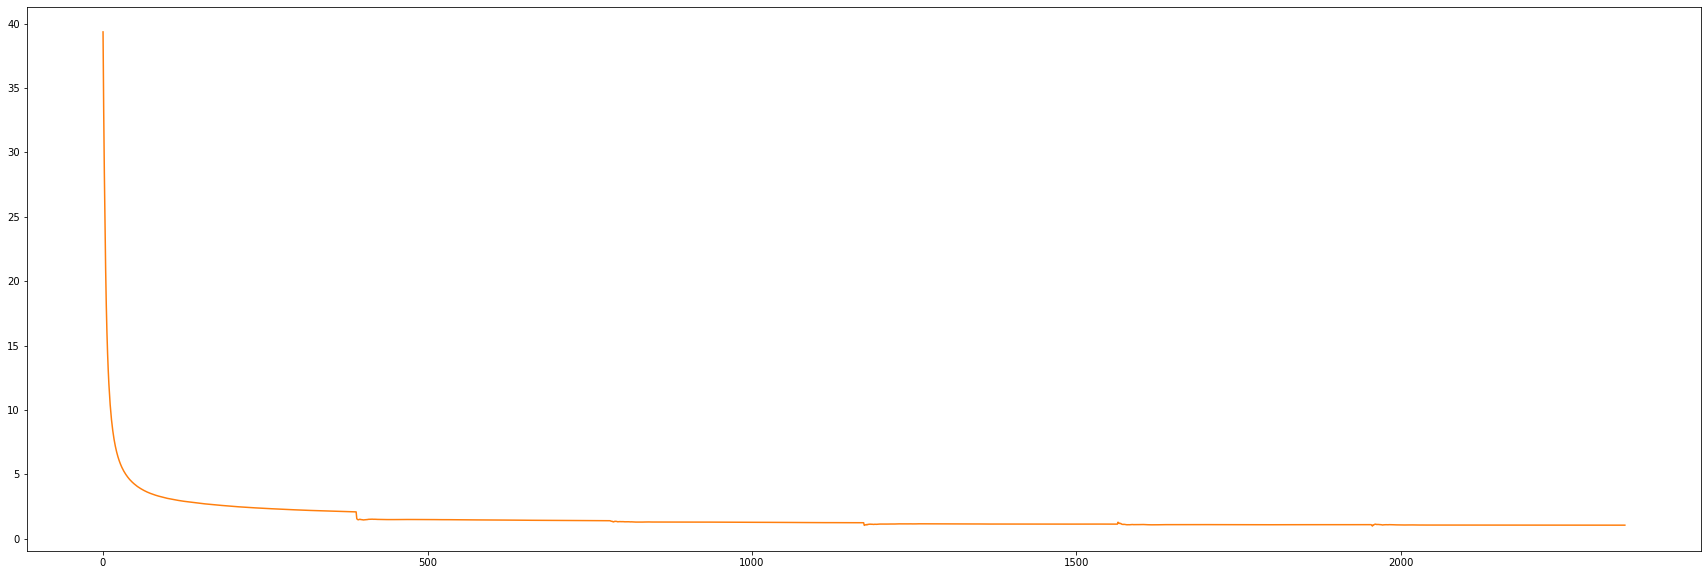

In [32]:
plt.figure(figsize=(30,10))
plt.plot(losses,color='#ff7f0e')
plt.show()

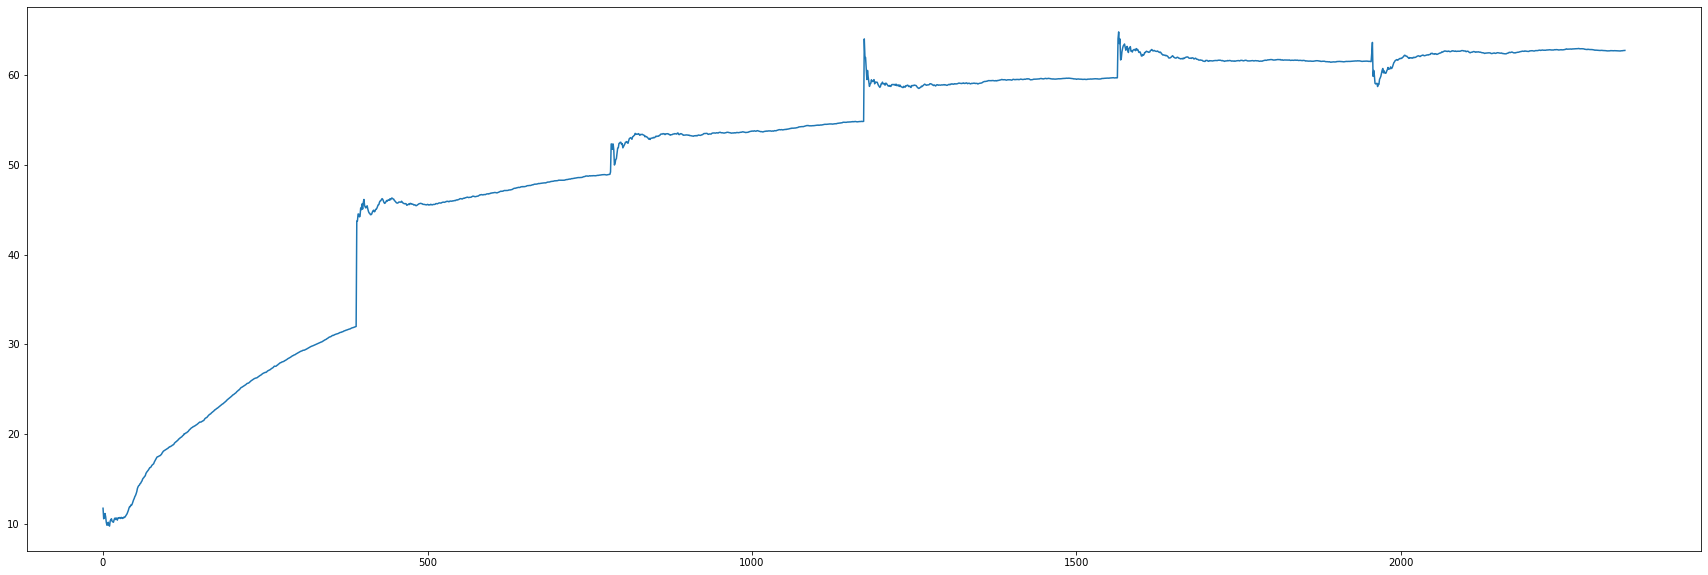

In [33]:
plt.figure(figsize=(30,10))
plt.plot(train_acc)#,color='#ff7f0e')
plt.show()

In [34]:
model.save_weights("cifar.dump")

Prediction:  truck 
Correct answer:  truck


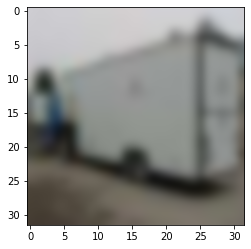

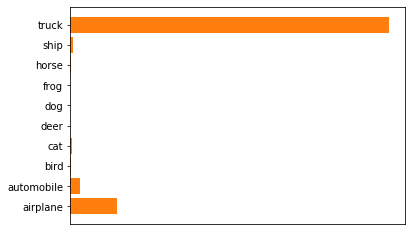

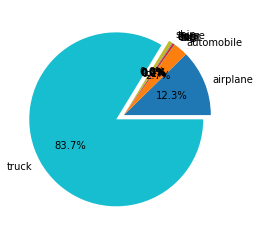

In [93]:
ck=np.random.randint(0,50000)
inp,y_inp=dt.batch_gen(size=1,ck=ck)
logits=model.predict(inp)
ans=logits.argmax(axis=1)
cor=y_inp.argmax(axis=1)
logits=logits[0]
print("Prediction: ",dt.names[int(ans[0])],"\nCorrect answer: ",dt.names[int(cor[0])])
plt.imshow(inp[0],interpolation='bicubic')
plt.show()
plt.barh(range(len(logits)),logits,color='#ff7f0e')
plt.yticks(range(len(logits)),dt.names)
plt.xticks([])
plt.show()
explode=np.zeros(10)
explode[ans]=0.1
plt.pie(logits,labels=dt.names,autopct='%1.1f%%',explode=explode)
plt.show()

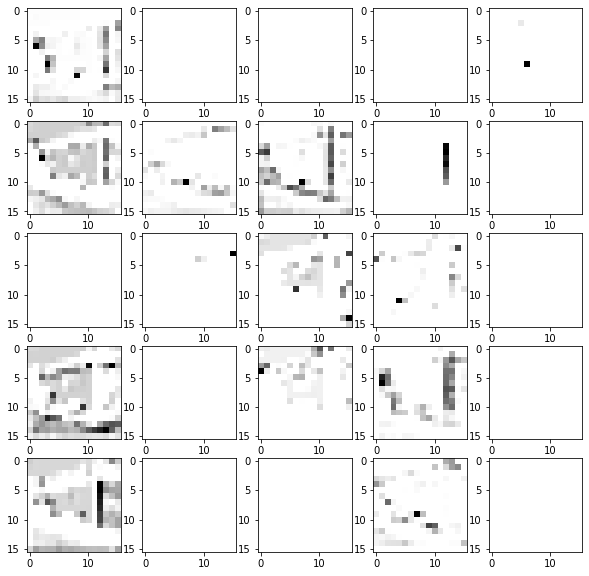

In [94]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
pme=model.sequence[3].z_out[0].transpose(2,0,1)
for i,axi in enumerate(ax.flat):
    axi.imshow(pme[i].reshape(pme.shape[-2:]), cmap='Greys')